In [30]:
%load_ext autoreload
%autoreload 2

from src.models.gps import GPS
from src.models.explainer.explainer_pipeline import ExplainerPipeline
from src.data import loader
from src.data.utils.utils import merge_pe_with_x
from src.models.explainer.attention_explainer import AttentionExplainer
from src.models.model import test
from src.models.utils.hooks import GPSHook

from torch_geometric.explain.config import ThresholdType, ModelConfig, ThresholdConfig
from torch_geometric.explain.algorithm import CaptumExplainer
from torch import tensor, set_default_dtype, float32

import networkx as nx

import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# AttentionExplainer benchmark
- GPS

## BAShapes
- 75 nodes
- ~300 edges
- 10 house motifs

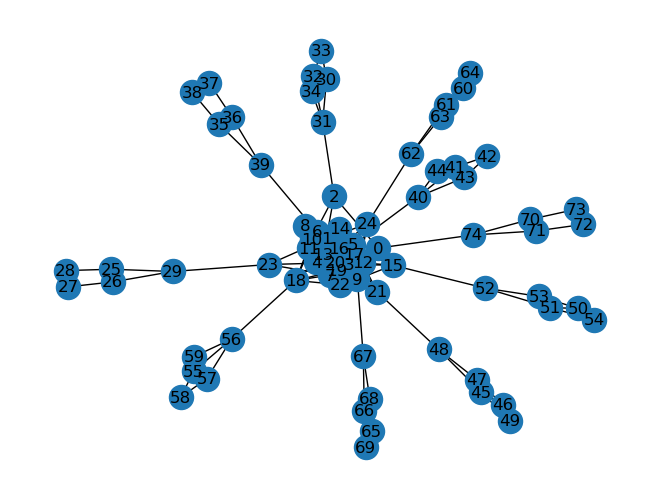

In [31]:
ba_shapes, ba_shapes_num_classes, ba_shapes_data_networkx = loader.load_clean_bashapes(num_nodes=25, num_edges=5, num_motifs=10, laplacian_eigenvector_dimensions=2)
nx.draw(ba_shapes_data_networkx, with_labels=True)

In [32]:
ba_shapes_explainer_params = {
    'explanation_type': 'model',
    'node_mask_type': 'attributes',
    'edge_mask_type': 'object',
    'model_config': ModelConfig(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',
    ),
}

ba_shapes_explainer_pipelines = {
    "gps": ExplainerPipeline(
        ba_shapes,
        ba_shapes_num_classes,
        GPS,
        AttentionExplainer,
        model_params={
            'pe_channels': 2,
            'num_layers': 4,
            'hidden_channels': 4,
            'num_attention_heads': 1,
            'observe_attention': True
        },
        explainer_params=ba_shapes_explainer_params,
        epochs=400,
        Hook=GPSHook
    )
}

100%|██████████| 400/400 [00:02<00:00, 179.04it/s]


Evaluate model performance.

In [33]:
gps_train_acc, gps_test_acc = test(ba_shapes_explainer_pipelines["gps"].model, ba_shapes)

print(f"GPS train accuracy: {gps_train_acc}")
print(f"GPS test accuracy: {gps_test_acc}")

GPS train accuracy: 0.26666666666666666
GPS test accuracy: 0.26666666666666666


Generate and evaluate explanation for node 26, which is in a house motif. Do the same for node 0, which is in the Barabasi-Albert graph.

In [34]:
nodes = [26, 0]
for model in ba_shapes_explainer_pipelines:
    for node in nodes:
        ba_shapes_explainer_pipelines[model].explain(node, laplacian_eigenvector_pe=ba_shapes.laplacian_eigenvector_pe, attention_computation_method="shortest_path", top_k=10)

Visualize GPS explanations.

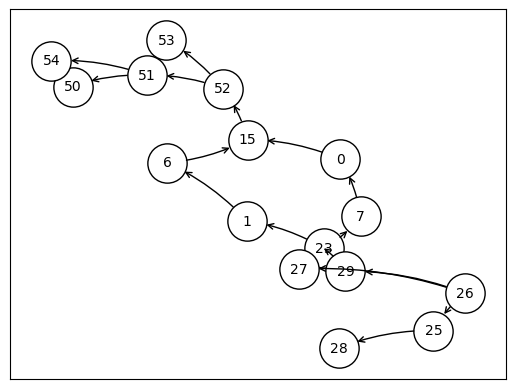

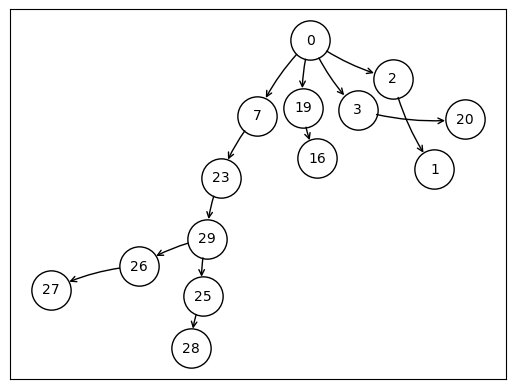

In [35]:
ba_shapes_explainer_pipelines["gps"].explanations[26].visualize_graph()
ba_shapes_explainer_pipelines["gps"].explanations[0].visualize_graph()

Evaluate explanations.

In [36]:
metrics = []
for model in ba_shapes_explainer_pipelines:
    for node in nodes:
        metrics.append([model, node, ba_shapes_explainer_pipelines[model].get_explanation_metrics(node)])

for metric in metrics:
    print(f"Model: {metric[0]}")
    print(f"Node: {metric[1]}")
    print(f"Explanation (accuracy, recall, precision, f1_score): {metric[2]}")
    print("\n")

for model in ba_shapes_explainer_pipelines:
    print(f"Model: {model}")
    pos, neg, characterization = ba_shapes_explainer_pipelines[model].get_entire_explanation_fidelity(laplacian_eigenvector_pe=ba_shapes.laplacian_eigenvector_pe, disable_tqdm=True)
    print(f"Positive explanation fidelity: {pos}")
    print(f"Negative explanation fidelity: {neg}")
    print(f"Characterization score: {characterization}")
    print("\n")


Model: gps
Node: 26
Explanation (accuracy, recall, precision, f1_score): (0.9407894611358643, 0.1875, 0.375, 0.25)


Model: gps
Node: 0
Explanation (accuracy, recall, precision, f1_score): (0.8848684430122375, 0.3076923191547394, 0.13333334028720856, 0.1860465109348297)


Model: gps


100%|██████████| 50/50 [00:00<00:00, 141.26it/s]

Positive explanation fidelity: 0.06
Negative explanation fidelity: 0.08
Characterization score: 0.1126530612244898




Run one more experiment for integrated gradients, using the trained GPS model on BA-Shapes.

100%|██████████| 400/400 [00:01<00:00, 204.16it/s]


GPS train accuracy: 0.13333333333333333
GPS test accuracy: 0.13333333333333333


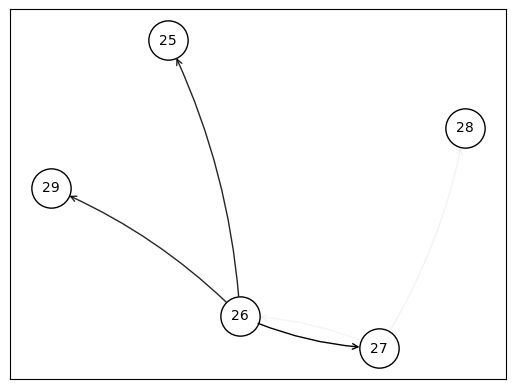

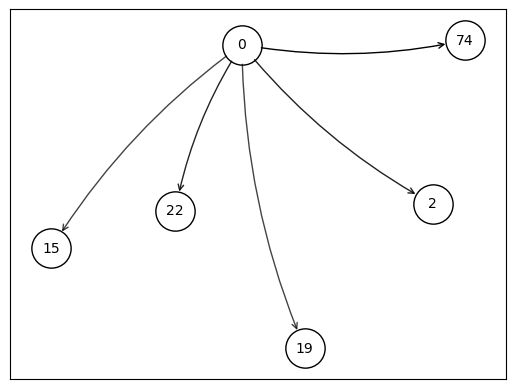

Model: gps
Node: 26
Explanation (accuracy, recall, precision, f1_score): (0.9835526347160339, 0.800000011920929, 0.5, 0.6153846383094788)


Model: gps
Node: 0
Explanation (accuracy, recall, precision, f1_score): (0.9177631735801697, 1.0, 0.1666666716337204, 0.2857142984867096)


Model: gps


100%|██████████| 50/50 [00:09<00:00,  5.52it/s]

Positive explanation fidelity: 0.76
Negative explanation fidelity: 0.0
Characterization score: 0.8636363636363636




In [37]:
ba_shapes_ig = merge_pe_with_x(ba_shapes, laplacian_eigenvector_pe=ba_shapes.laplacian_eigenvector_pe)
ba_shapes_explainer_params_ig = {
    'explanation_type': 'model',
    'node_mask_type': 'attributes',
    'edge_mask_type': 'object',
    'model_config': ModelConfig(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',
    ),
}

ba_shapes_explainer_pipelines_ig = {
    "gps": ExplainerPipeline(
        ba_shapes_ig,
        ba_shapes_num_classes,
        GPS,
        CaptumExplainer,
        model_params={
            'pe_channels': 2,
            'num_layers': 4,
            'hidden_channels': 4,
            'num_attention_heads': 1,
            'observe_attention': True, 
            'integrated_gradients': True
        },
        explainer_params={
            **ba_shapes_explainer_params_ig,
            "threshold_config": ThresholdConfig(threshold_type='topk', value=5),
        },
        epochs=400,
    )
}

gps_train_acc, gps_test_acc = test(ba_shapes_explainer_pipelines_ig["gps"].model, ba_shapes_ig)
print(f"GPS train accuracy: {gps_train_acc}")
print(f"GPS test accuracy: {gps_test_acc}")

nodes = [26, 0]
for model in ba_shapes_explainer_pipelines_ig:
    for node in nodes:
        ba_shapes_explainer_pipelines_ig[model].explain(node, laplacian_eigenvector_pe=ba_shapes.laplacian_eigenvector_pe)

ba_shapes_explainer_pipelines_ig["gps"].explanations[26].visualize_graph()
ba_shapes_explainer_pipelines_ig["gps"].explanations[0].visualize_graph()

metrics = []
for model in ba_shapes_explainer_pipelines_ig:
    for node in nodes:
        metrics.append([model, node, ba_shapes_explainer_pipelines_ig[model].get_explanation_metrics(node)])

for metric in metrics:
    print(f"Model: {metric[0]}")
    print(f"Node: {metric[1]}")
    print(f"Explanation (accuracy, recall, precision, f1_score): {metric[2]}")
    print("\n")

for model in ba_shapes_explainer_pipelines_ig:
    print(f"Model: {model}")
    pos, neg, characterization = ba_shapes_explainer_pipelines_ig[model].get_entire_explanation_fidelity(laplacian_eigenvector_pe=ba_shapes.laplacian_eigenvector_pe, disable_tqdm=True)
    print(f"Positive explanation fidelity: {pos}")
    print(f"Negative explanation fidelity: {neg}")
    print(f"Characterization score: {characterization}")
    print("\n")

## PascalVOC-SP
- 499 nodes
- 2826 edges

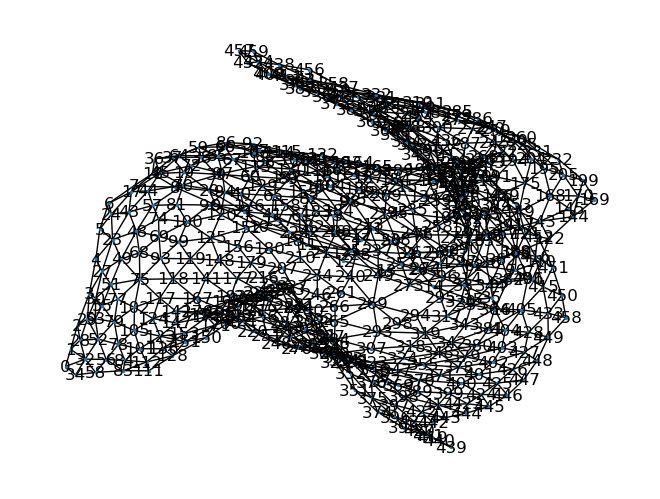

In [38]:
pascalvoc_sp, pascalvoc_sp_num_classes, pascal_voc_sp_data_networkx = loader.load_clean_pascalvoc_sp(3)
nx.draw(pascal_voc_sp_data_networkx, with_labels=True, node_size=2)

In [39]:
pascalvoc_sp_explainer_params = {
    'explanation_type': 'model',
    'node_mask_type': 'attributes',
    'edge_mask_type': 'object',
    'model_config': ModelConfig(
        mode='binary_classification',
        task_level='node',
        return_type='raw',
    )
}

pascalvoc_sp_explainer_pipelines = {
    "gps": ExplainerPipeline(
        pascalvoc_sp,
        pascalvoc_sp_num_classes,
        GPS,
        AttentionExplainer,
        model_params={
            'pe_channels': 5,
            'num_layers': 2,
            'hidden_channels': 4,
            'num_attention_heads': 4,
            'observe_attention': True
        },
        explainer_params=pascalvoc_sp_explainer_params,
        epochs=400,
        Hook=GPSHook
    ),
}

100%|██████████| 400/400 [00:44<00:00,  9.05it/s]


Evaluate model performance.

In [40]:
gps_train_acc, gps_test_acc = test(pascalvoc_sp_explainer_pipelines["gps"].model, pascalvoc_sp)

print(f"GPS train accuracy: {gps_train_acc}")
print(f"GPS test accuracy: {gps_test_acc}")

GPS train accuracy: 0.9849624060150376
GPS test accuracy: 1.0


Generate and evaluate explanation for two arbitrary nodes.

In [41]:
nodes = random.sample(range(0, pascalvoc_sp.num_nodes), 2)
for model in pascalvoc_sp_explainer_pipelines:
    for node in nodes:
        pascalvoc_sp_explainer_pipelines[model].explain(node, random_walk_pe=pascalvoc_sp.random_walk_pe, attention_computation_method="shortest_path", top_k=10)

Visualize GPS explanations.

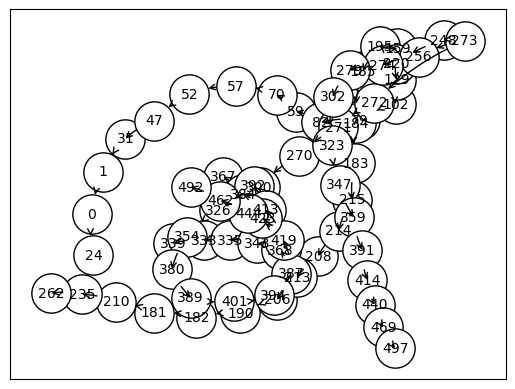

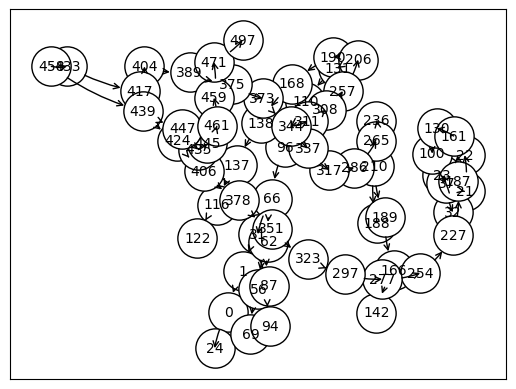

In [42]:
for node in nodes:
    pascalvoc_sp_explainer_pipelines["gps"].explanations[node].visualize_graph()

Evaluate explanations.

In [43]:
for model in pascalvoc_sp_explainer_pipelines:
    print(f"Model: {model}")
    pos, neg, characterization = pascalvoc_sp_explainer_pipelines[model].get_entire_explanation_fidelity(random_walk_pe=pascalvoc_sp.random_walk_pe, disable_tqdm=True, attention_computation_method="shortest_path", top_k=10)
    print(f"Positive explanation fidelity: {pos}")
    print(f"Negative explanation fidelity: {neg}")
    print(f"Characterization score: {characterization}")
    print("\n")


Model: gps


100%|██████████| 50/50 [00:11<00:00,  4.52it/s]

Positive explanation fidelity: 0.0
Negative explanation fidelity: 0.12
Characterization score: 0.0




Run one more experiment for integrated gradients, using the trained GPS model on PascalVOC-SP.

100%|██████████| 400/400 [00:43<00:00,  9.25it/s]


GPS train accuracy: 1.0
GPS test accuracy: 0.99


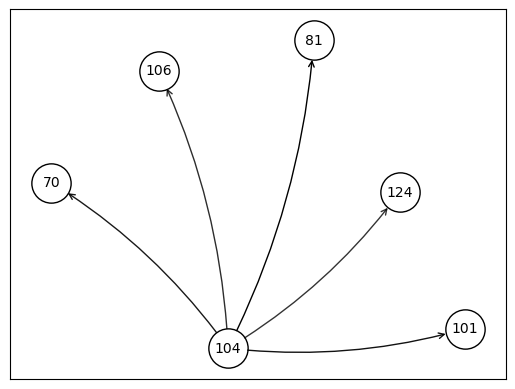

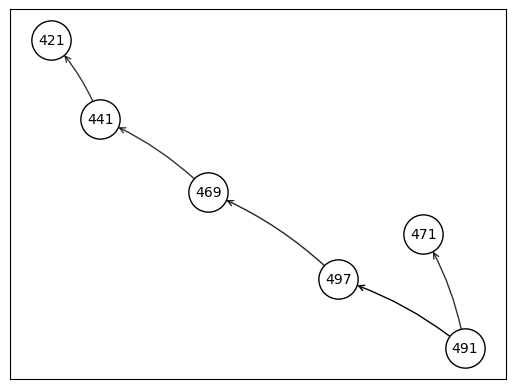

Model: gps


100%|██████████| 50/50 [04:19<00:00,  5.18s/it]

Positive explanation fidelity: 0.46
Negative explanation fidelity: 0.08
Characterization score: 0.6133333333333333




In [44]:
pascalvoc_sp_ig = merge_pe_with_x(pascalvoc_sp, random_walk_pe=pascalvoc_sp.random_walk_pe)
pascalvoc_sp_explainer_params_ig = {
    'explanation_type': 'model',
    'node_mask_type': 'attributes',
    'edge_mask_type': 'object',
    'model_config': ModelConfig(
        mode='binary_classification',
        task_level='node',
        return_type='probs', # fix the GPS architecture to output probs in model_params
    )
}

pascalvoc_sp_explainer_pipelines_ig = {
    "gps": ExplainerPipeline(
        pascalvoc_sp_ig,
        pascalvoc_sp_num_classes,
        GPS,
        CaptumExplainer,
        model_params={
            'pe_channels': 5,
            'num_layers': 2,
            'hidden_channels': 4,
            'num_attention_heads': 4,
            'observe_attention': True,
            "integrated_gradients": True
        },
        explainer_params={
            **pascalvoc_sp_explainer_params_ig,
            "threshold_config": ThresholdConfig(threshold_type='topk', value=5),
        },
        epochs=400,
    ),
}

gps_train_acc, gps_test_acc = test(pascalvoc_sp_explainer_pipelines_ig["gps"].model, pascalvoc_sp_ig)

print(f"GPS train accuracy: {gps_train_acc}")
print(f"GPS test accuracy: {gps_test_acc}")

nodes = random.sample(range(0, pascalvoc_sp_ig.num_nodes), 2)
for model in pascalvoc_sp_explainer_pipelines_ig:
    for node in nodes:
        pascalvoc_sp_explainer_pipelines_ig[model].explain(node, random_walk_pe = pascalvoc_sp.random_walk_pe) # fix random walk pe issue not being passed to forward call of my model via captumExplainer

for node in nodes:
    pascalvoc_sp_explainer_pipelines_ig["gps"].explanations[node].visualize_graph()

for model in pascalvoc_sp_explainer_pipelines_ig:
    print(f"Model: {model}")
    pos, neg, characterization = pascalvoc_sp_explainer_pipelines_ig[model].get_entire_explanation_fidelity(random_walk_pe=pascalvoc_sp.random_walk_pe, disable_tqdm=True)
    print(f"Positive explanation fidelity: {pos}")
    print(f"Negative explanation fidelity: {neg}")
    print(f"Characterization score: {characterization}")
    print("\n")